In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Loading Data
data = dict()
data["fake"]  = pd.read_csv("fusers.csv")
data["legit"] = pd.read_csv("users.csv")

In [64]:
# Removing unnecessary columns
data["legit"] = data["legit"].drop([ "id","name", "screen_name", "created_at", "lang", "location", "default_profile", "default_profile_image", "geo_enabled", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated", "description"], axis=1)
data["fake"]  = data["fake"].drop(["id","name", "screen_name", "created_at", "lang", "location", "default_profile", "default_profile_image", "geo_enabled", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated", "description"], axis=1)

In [65]:
print("Final Available Columns")
data["legit"].columns

Final Available Columns


Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'url', 'time_zone'],
      dtype='object')

In [66]:
# Converting DataFrame to Numpy Array
data["legit"] = data["legit"].values
data["fake"] = data["fake"].values

In [67]:
for i in range(len(data["legit"])):
    if type(data["legit"][i][5]) == str:
        data["legit"][i][5] = 1
    
    if type(data["legit"][i][6]) == str:
        data["legit"][i][6] = 1
        
for i in range(len(data["fake"])):
    if type(data["fake"][i][5]) == str:
        data["fake"][i][5] = 1
    
    if type(data["fake"][i][6]) == str:
        data["fake"][i][6] = 1

In [68]:
data["legit"] = data["legit"].astype(np.float64)
data["fake"] = data["fake"].astype(np.float64)

In [69]:
where_nans = np.isnan(data["legit"])
data["legit"][where_nans] = 0

where_nans = np.isnan(data["fake"])
data["fake"][where_nans] = 0

In [70]:
X = np.zeros((len(data["fake"]) + len(data["legit"]), 7))
Y = np.zeros(len(data["fake"]) + len(data["legit"]))

In [71]:
for i in range(len(data["legit"])):
    X[i] = data["legit"][i]/max(data["legit"][i])
    Y[i] = -1

for i in range(len(data["fake"])):
    bound = max(data["fake"][i])
    if bound == 0:
        bound = 1
    
    X[len(data["legit"])+i] = data["fake"][i]/bound # Normalizing Data [0 <--> 1]
    Y[len(data["legit"])+i] = 1

# Splitting Dataset into Train and Test

In [72]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, 
    test_size=0.20, random_state=45)

# Loading Deep Learning libraries

In [73]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping, Callback

from IPython.display import clear_output

## Initializing Early Stopping Callback to prevent training proceed to overfitting.

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Creating Accuracy Loss Graph callback

In [75]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
        
plot = PlotLearning()

##  Building Predictive Model

In [76]:
model = Sequential([
    BatchNormalization(),
    
    Dense(16, activation="relu", kernel_regularizer="l2"),
    BatchNormalization(),
    Dense(8, activation="relu", kernel_regularizer="l2"),
    BatchNormalization(),
    Dense(1, activation="tanh"),
])

model.build((None, X.shape[1]))
model.summary()
model.compile(
    optimizer="adamax",
    loss="mse",
    metrics=["acc"]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 16)                128       
                                                                 
 batch_normalization_7 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 batch_normalization_8 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                      

# Iterative Training Process Begins...

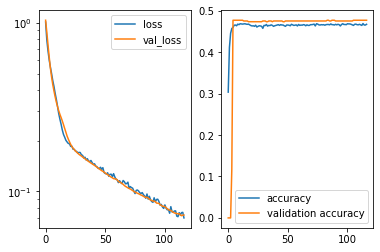

23/23 [==============================] - 1s 41ms/step - loss: 0.0697 - acc: 0.4672 - val_loss: 0.0725 - val_acc: 0.4770


In [77]:
model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), shuffle=True, batch_size=100, callbacks=[early_stopping, plot])

In [78]:
logits = model.predict(X_test).T[0]

18/18 [==============================] - 0s 2ms/step


In [79]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 0.0725 - acc: 0.4770


[0.0725298821926117, 0.47695034742355347]

In [80]:
for i in range(len(logits)):
    logits[i] = -1 if logits[i] < 0 else 1

In [81]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
mat = confusion_matrix(y_test, logits)
print(mat)

[[291   3]
 [  1 269]]


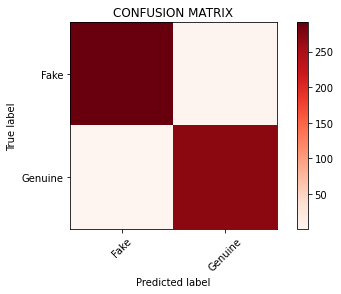

In [83]:
plot_confusion_matrix(mat)

# Validation Accuracy

In [84]:
_, train_acc = model.evaluate(X_train, y_train)
_, val_acc = model.evaluate(X_test, y_test)
print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

18/18 [==============================] - 0s 4ms/step - loss: 0.0725 - acc: 0.4770
Train Accuracy: 0.46894410252571106
Validation Accuracy: 0.47695034742355347


In [127]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators=50,learning_rate=0.6)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [128]:
y_pred

array([-1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
        1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1

In [129]:
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn import metrics
model_columns = []
model_compare = pd.DataFrame(columns = model_columns)

row_index = 0
for alg in model: 
    predicted = alg.fit(X_train, y_train).predict(X_test)
    model_compare.loc[row_index, 'model Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    model_compare.loc[row_index, 'model Precission'] = precision_score(y_test, predicted)
    model_compare.loc[row_index, 'model Recall'] = recall_score(y_test, predicted)
    model_compare.loc[row_index, 'model f1_score'] = f1_score(y_test, predicted)

model_compare.sort_values(by = ['model Test Accuracy'], ascending = False, inplace = True)    
model_compare

,model Test Accuracy,model Precission,model Recall,model f1_score
0,0.9805,0.967509,0.992593,0.97989


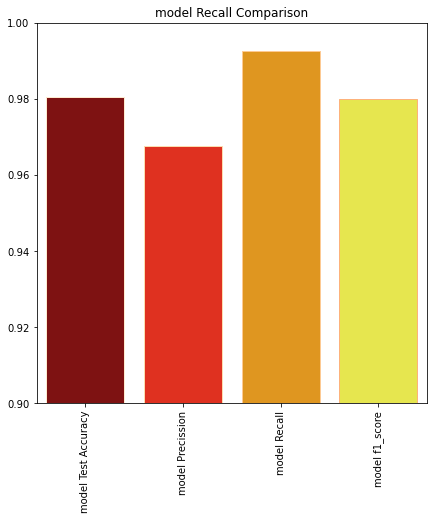

In [130]:
import seaborn as sns

plt.subplots(figsize=(7,7))
sns.barplot(data=model_compare,palette='hot',edgecolor=sns.color_palette('OrRd',9))
data=[]
data.append(round(alg.score(X_test, y_test), 4))
data.append(precision_score(y_test, predicted))
data.append(recall_score(y_test, predicted))
data.append(f1_score(y_test, predicted))
label=['model Test Accuracy',"Precision score","recall Score","f1 Score"]
plt.xticks(rotation=90)
plt.ylim([0.9,1])
plt.title('model Recall Comparison')
plt.show()

In [131]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
y=accuracy
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.29%


In [132]:
ada=AdaBoostClassifier(n_estimators=100,learning_rate=0.6)
ada.fit(X_train,y_train)
ada_pred=ada.predict(X_test)
acc_ada=round(accuracy_score(y_test,ada_pred),3)
print("Accuracy: %.2f%%" % (acc_ada * 100.0))

Accuracy: 99.50%


C:\Users\DIVYA PRAJAPATI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


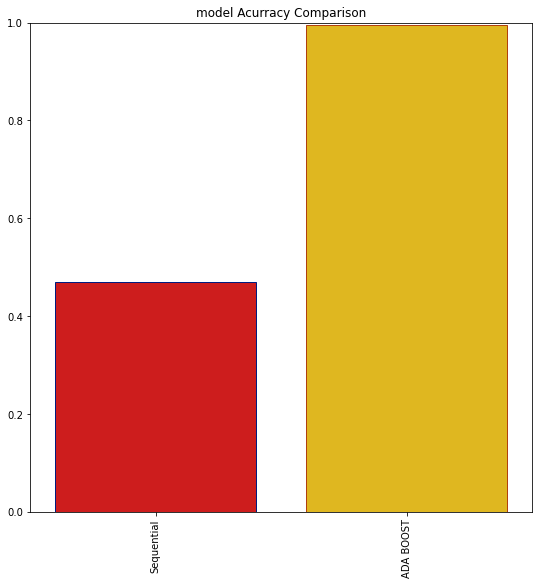

In [91]:
plt.subplots(figsize=(9,9))
data=[]
data.append(train_acc)
data.append(acc_ada)
label=['Sequential','ADA BOOST']
sns.barplot(label,data,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.title('model Acurracy Comparison')
plt.show()

In [142]:
model1=AdaBoostClassifier().fit(X_train,y_train)

In [145]:
import tkinter as tk
from tkinter import *

def values():
    global status
    status=float(statusentry.get())
    global followers
    followers=float(Followersentry.get())
    global friends
    friends=float(Friendsentry.get())
    global favourites
    favourites=float(Favouritesentry.get())
    global listed
    listed=float(Listedentry.get())
    global url
    url=float(URLentry.get())
    global timezone
    timezone=float(Timezoneentry.get())
    
    result=model1.predict([[status,followers,friends,favourites,listed,url,timezone]])
    if result==-1:
        output="Real"
    else:
        output="Fake"
    outcomeentry.delete(-1,END)    
    outcomeentry.insert(-1,str(output))

    

In [146]:
root=tk.Tk()
root.title("Detection")

title=Label(root,text="Check Profile",bg="red",fg="yellow",font=('Arial Black',32),padx=20,pady=20)
title.grid(row=0,column=4)

status=Label(root,text="Status",font=('Arial Black',18))
status.grid(row=3,column=1)
statusentry=tk.Entry(root)
statusentry.grid(row=3,column=2,padx=30,pady=30)

followers_count=Label(root,text="Followers",font=('Arial Black',18))
followers_count.grid(row=4,column=1)
Followersentry=tk.Entry(root)
Followersentry.grid(row=4,column=2,padx=30,pady=30)

friends_count=Label(root,text="Friends",font=('Arial Black',18))
friends_count.grid(row=5,column=1)
Friendsentry=tk.Entry(root)
Friendsentry.grid(row=5,column=2,padx=30,pady=30)

favourites_count=Label(root,text="Favourite",font=('Arial Black',18))
favourites_count.grid(row=6,column=1)
Favouritesentry=tk.Entry(root)
Favouritesentry.grid(row=6,column=2,padx=30,pady=30)

listed_count=Label(root,text="Listed",font=('Arial Black',18))
listed_count.grid(row=7,column=1)
Listedentry=tk.Entry(root)
Listedentry.grid(row=7,column=2,padx=30,pady=30)


url=Label(root,text="URL",font=('Arial Black',18))
url.grid(row=8,column=1)
URLentry=tk.Entry(root)
URLentry.grid(row=8,column=2,padx=30,pady=30)


time_zone=Label(root,text="Time Zone",font=('Arial Black',18))
time_zone.grid(row=9,column=1)
Timezoneentry=tk.Entry(root)
Timezoneentry.grid(row=9,column=2,padx=30,pady=30)


outcome=Label(root,text="outcome",font=('Arial Black',18))
outcome.grid(row=7,column=4)
outcomeentry=tk.Entry(root)
outcomeentry.grid(row=7,column=5)

button=tk.Button(root,text="calculate",command=values,bg="orange",fg="black",font=('Arial Black',20))
button.grid(row=6,column=4)

root.mainloop()